In [1]:
# importing the modules  
import skimage
from skimage import measure
from skimage.morphology import convex_hull_image,disk
import numpy as np 
import cv2
import matplotlib.pyplot as plt 
import pandas as pd 
import tqdm 
import torch
from model.unet import Unet

# MOdel Loading

In [3]:
model_unet = Unet()
model_unet = torch.load('best.ckpt',map_location= 'cpu')
#model_unet.load_state_dict(weights)
model_unet.eval()

Using cache found in C:\Users\mHealth-11/.cache\torch\hub\milesial_Pytorch-UNet_master


Unet(
  (model): UNet(
    (inc): DoubleConv(
      (double_conv): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (down1): Down(
      (maxpool_conv): Sequential(
        (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (1): DoubleConv(
          (double_conv): Sequential(
            (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
            (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1

# Loading the image for prediction

In [4]:
# Loading the image for prediction
img0 = cv2.imread('view1_frontal.jpg',1)
img0 = cv2.resize(img0, (256, 256))
print(img0.shape)

(256, 256, 3)


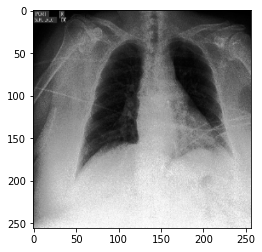

In [5]:
plt.imshow(img0, cmap = 'gray')

In [6]:
x_o = np.expand_dims(img0, 0).transpose((0,3,1,2))
#x0 = torch.permute(x_o, (0,3,1,2))
x_o = (x_o- x_o.min())/(x_o.max()-x_o.min())
xx= torch.tensor(x_o)
x_mask = (torch.sigmoid(model_unet(xx.float())).squeeze().cpu().data.numpy())

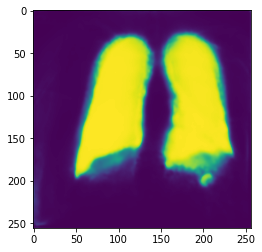

In [7]:
plt.imshow(x_mask)
plt.show()

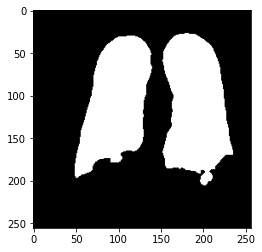

In [8]:
# integer conversion and making binary
lung_mask = x_mask #pred_mask[0]
lung_mask_norm = (lung_mask - lung_mask.min())*((255 - 0)/(lung_mask.max()- lung_mask.min()))+ 0
lung_mask_norm = lung_mask_norm.astype('uint8')
_, bw_mask = cv2.threshold(lung_mask_norm, 0 , 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
plt.imshow(bw_mask, cmap = 'gray')

In [9]:
# Keep the largest two areas in the musk 
#bw_mask = x_mask
input_mask = bw_mask 
labels_mask = measure.label(input_mask)                       
regions = measure.regionprops(labels_mask)
regions.sort(key=lambda x: x.area, reverse=True)
if len(regions) > 2:
    for rg in regions[2:]:
        labels_mask[rg.coords[:,0], rg.coords[:,1]] = 0
labels_mask[labels_mask!=0] = 1
mask = labels_mask

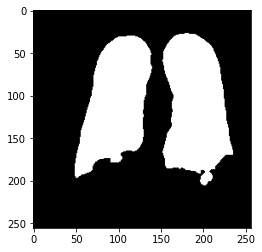

In [10]:
plt.imshow(mask, cmap='gray')

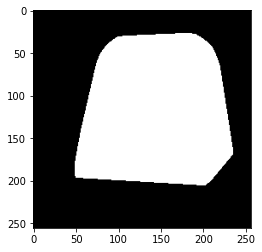

In [11]:
mask = convex_hull_image(mask)
plt.imshow(mask, cmap='gray')

## Musk Multiplication with original image 

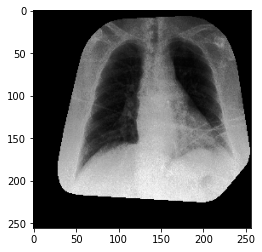

In [12]:
# multiplication of mask with the original image and segment the area of interest 
kernel = disk(10)
        # over the image and structuring element
mask = cv2.dilate(mask.astype('uint8'), kernel, iterations = 2)
img0_gray = cv2.cvtColor(img0, cv2.COLOR_BGR2GRAY)
seg_lung = img0_gray*mask.astype('uint8')
plt.imshow(seg_lung, cmap = 'gray')

## Contrast Limited Adaptive Histogram Equalization

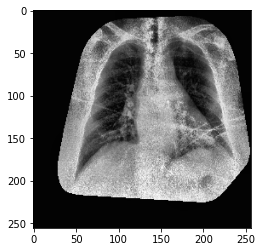

In [13]:
# Contrast Limited Adaptive Histogram Equalization
clahe = cv2.createCLAHE(clipLimit=3, tileGridSize=(8,8))
clahe_img = clahe.apply(seg_lung)
plt.imshow(clahe_img, cmap = 'gray')

## LUT operations 

In [14]:
# Load image as greyscale and make into Numpy array
grey = clahe_img
# Load RGB LUT from CSV file
lutframe = pd.read_csv('LUT_unicorn.csv', dtype=np.uint8, delimiter=',')
lut = lutframe.iloc[:,[1,2,3]].values

# Make output image, same height and width as grey image, but 3-channel RGB
result = np.zeros((*grey.shape,3), dtype=np.uint8)

# Take entries from RGB LUT according to greyscale values in image
result = np.take(lut, grey, axis=0)
plt.imshow(result)

FileNotFoundError: [Errno 2] No such file or directory: 'LUT_unicorn.csv'

In [15]:
import os 

pw = os.getcwd()

folder = 'folder1\\folder2\\folder3'
folder2 = 'folder1\\folder2\\folder4'
#os.makedirs(os.path.join(pw, folder2))

In [ ]:
#os.makedirs(os.path.join(pw, folder2))

In [ ]:
if 'folder' in folder: 
    print('True')

In [ ]:
import tqdm
from skimage.morphology import disk, erosion, dilation


In [ ]:
label_path = './data/CheXpert-v1.0-small/dev.csv'

In [ ]:
with open(label_path) as f:
    header = f.readline().strip('\n').split(',')
    lines=f.readlines()
    #count = 0 ; 
    for line in tqdm.tqdm(lines):
        #if count == 20:
        #    break
        #count+=1
        
        fields = line.strip('\n').split(',')
        #print(line)
        img_path = fields[0]
        img_path_with_base = './data/' + img_path # path from where image is taken 
        #         img_view = fields[3]
        #         print(img_path)
        #         print(img_view)
        assert os.path.exists(img_path_with_base), 'The path '+img_path_with_base+' doesnt exist'
        
        
        ### Grab the image and do the segmentation.
        
        # Loading the image for prediction
        img0 = cv2.imread(img_path_with_base,1)
        #img512 = cv2.resize(img0,(512,512))
        img0 = cv2.resize(img0, (256, 256))
        
        # Prediction of the musk with extension of dimension 
        #         b_img0 = tf.expand_dims(img0, 0)
        #         pred_mask =segmentation_model.predict(b_img0, steps = 1)
        x_o = np.expand_dims(img0, 0).transpose((0,3,1,2))
        #x0 = torch.permute(x_o, (0,3,1,2))
        x_o = (x_o- x_o.min())/(x_o.max()-x_o.min())
        xx= torch.tensor(x_o)
        x_mask = (torch.sigmoid(model_unet(xx.float())).squeeze().cpu().data.numpy())
        
        # integer conversion and making binary
        lung_mask = x_mask
        lung_mask_norm = (lung_mask - lung_mask.min())*((255 - 0)/(lung_mask.max()- lung_mask.min()))+ 0
        lung_mask_norm = lung_mask_norm.astype('uint8')
        _, bw_mask = cv2.threshold(lung_mask_norm, 0 , 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        
        
        # Keep the largest two areas in the musk 
        if fields[3] == 'Lateral':
        
        
            # for the side/lateral view 
            input_mask = bw_mask 
            labels_mask = measure.label(input_mask)                       
            regions = measure.regionprops(labels_mask)
            regions.sort(key=lambda x: x.area, reverse=True)
            if len(regions) > 1:
                for rg in regions[1:]:
                    labels_mask[rg.coords[:,0], rg.coords[:,1]] = 0
            labels_mask[labels_mask!=0] = 1
            mask = labels_mask
            
        else: 
            # for the frontal view 
            input_mask = bw_mask 
            labels_mask = measure.label(input_mask)                       
            regions = measure.regionprops(labels_mask)
            regions.sort(key=lambda x: x.area, reverse=True)
            if len(regions) > 2:
                for rg in regions[2:]:
                    labels_mask[rg.coords[:,0], rg.coords[:,1]] = 0
            labels_mask[labels_mask!=0] = 1
            mask = labels_mask
            
        
        mask = convex_hull_image(mask)
        
        #kernel = np.ones((10,10), np.uint8)
        kernel = disk(15)
        # over the image and structuring element
        mask = cv2.dilate(mask.astype('uint8'), kernel, iterations = 2)
        
        
        # multiplication of mask with the original image and segment the area of interest 
        img0_gray = cv2.cvtColor(img0, cv2.COLOR_BGR2GRAY)
        seg_lung = img0_gray*mask.astype('uint8')
        #img512_gray = cv2.cvtColor(img512, cv2.COLOR_BGR2GRAY)
        #mask512 = cv2.resize( mask,(512,512))
        #seg_lung = img512_gray*mask512.astype('uint8')
        #plt.imshow(seg_lung, cmap = 'gray')
        
        # Contrast Limited Adaptive Histogram Equalization
        ##clahe = cv2.createCLAHE(clipLimit=3, tileGridSize=(8,8))
        ##clahe_img = clahe.apply(seg_lung)
        
        # lut operation
        # Load image as greyscale and make into Numpy array
        # Take entries from RGB LUT according to greyscale values in image
        #result = np.take(lut, clahe_img, axis=0)
        result = seg_lung
        
        
        # save the result now 
        save_dir = '/'.join(img_path.split('/')[:-1])
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        cv2.imwrite(save_dir +'/'+ img_path.split('/')[-1], result)
        #print('./data/'+save_dir +'/'+ img_path.split('/')[-1])
        #plt.imshow(result)

        
        
        
        
        
        
        

        
        
        
        ## Code Running . Please don't Quit ##
        
        ####### ------ 0 ------ ########

In [ ]:
header

In [ ]:
# frontier 